## MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist.data, mnist.target
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

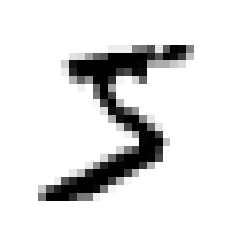

In [4]:
%matplotlib inline
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')
plt.show();

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

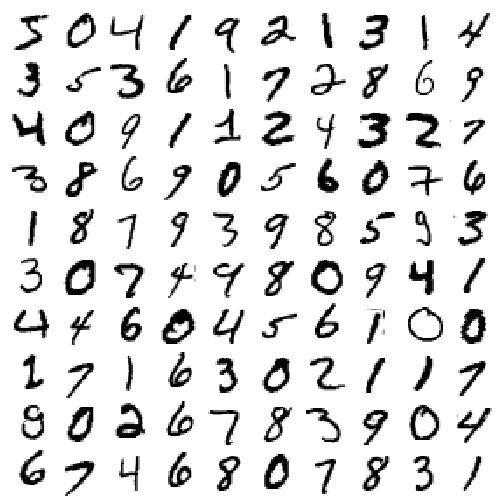

In [9]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show();

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_pred, y_train_5)

array([[53892,  1891],
       [  687,  3530]])

In [20]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[1, 1] + cm[0, 1])

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [24]:
cm[1, 1] / (cm[1, 1] + cm[1, 0])

0.6511713705958311

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [26]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [29]:
y_some_digit_pred

array([ True])

In [30]:
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method='decision_function')

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

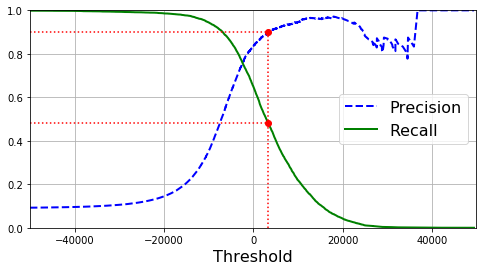

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions>=0.90)]
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                            
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                         
plt.show();

In [34]:
(y_train_pred == (y_scores > 0)).all()

True

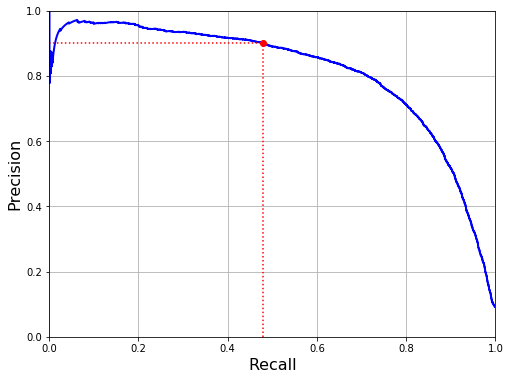

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show();

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [37]:
threshold_90_precision

3370.0194991439594

In [38]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC curves

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

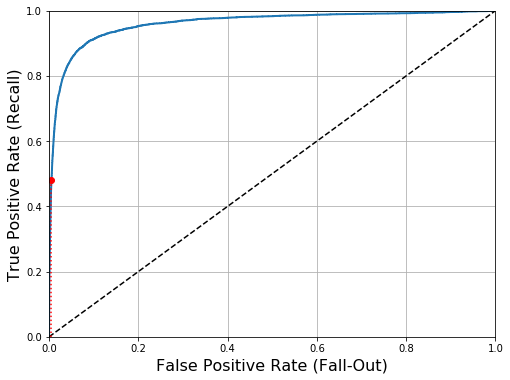

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))                                  
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]         
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")            
plt.show();

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method='predict_proba')

In [45]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

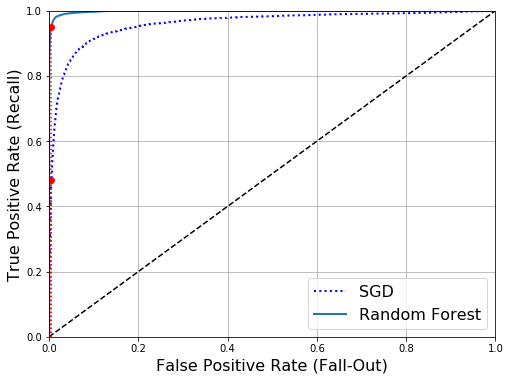

In [46]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show();

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [48]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [49]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass classification

In [50]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [52]:
np.argmax(some_digit_scores)

5

In [53]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [54]:
svm_clf.classes_[5]

5

In [55]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
len(ovr_clf.estimators_)

10

In [57]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [58]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

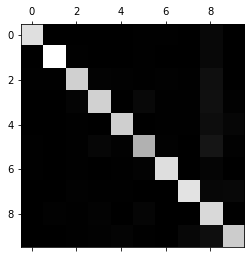

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show();

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

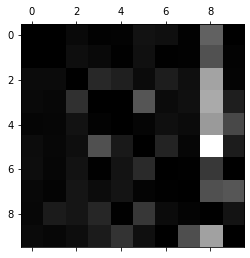

In [64]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show();

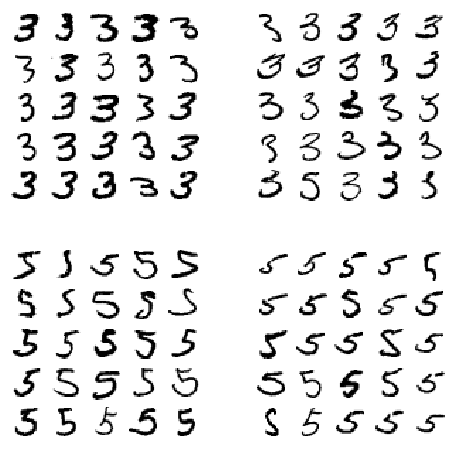

In [65]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show();

## Multilabel classification

In [66]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [67]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## Multioutput classification

In [69]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

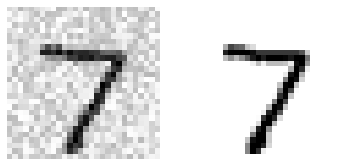

In [70]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show();

# Extra material
## Dummy (ie. random) classifier

In [71]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy='prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

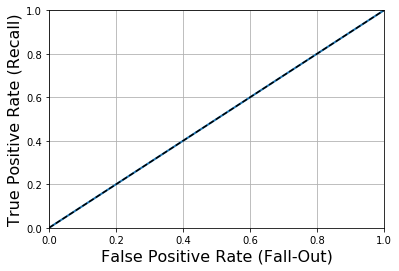

In [72]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [73]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [74]:
y_knn_pred = knn_clf.predict(X_test)

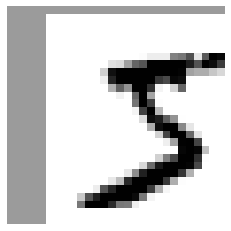

In [75]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [76]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [77]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [78]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [79]:
y_knn_expanded_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [81]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

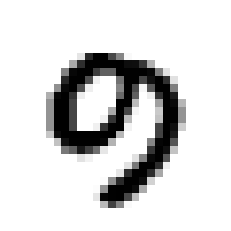

In [82]:
plot_digit(ambiguous_digit)

## Exercise solutions
1. An MNIST Classifier With Over 97% Accuracy

In [83]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=10.9min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.9min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=10.8min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 21.7min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=10.8min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=10.9min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=11.0min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=10.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=11.0min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=10.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=10.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 328.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [91]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [85]:
grid_search.best_score_

0.9716166666666666

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

2. Data Augmentation

In [94]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

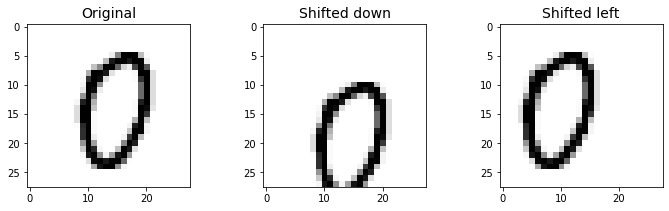

In [95]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5) 
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title('Original', fontsize=14)
plt.imshow(image.reshape(28,28), interpolation='nearest', cmap='Greys')
plt.subplot(132)
plt.title('Shifted down', fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation='nearest', cmap='Greys')
plt.subplot(133)
plt.title('Shifted left', fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation='nearest', cmap='Greys')
plt.show();

In [96]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

3. Tackle the Titanic dataset

In [1]:
import os

TITANIC_PATH = os.path.join('datasets', 'titanic')

In [2]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path=os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data('train_titanic.csv') 
test_data = load_titanic_data('test_titanic.csv')

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])), 
    ('imputer', SimpleImputer(strategy='median'))
])

In [13]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [14]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_=pd.Series([X[c].value_counts().index[0] for c in X],
                                     index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [15]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [16]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [17]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [18]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [19]:
y_train = train_data['Survived']

In [20]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [22]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

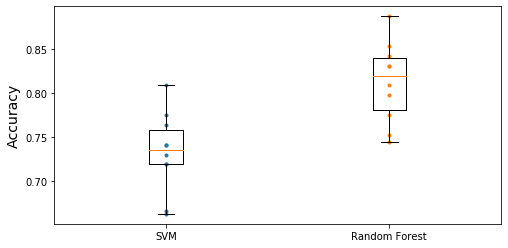

In [25]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy', fontsize=14)
plt.show();

In [26]:
train_data['AgeBucket'] = train_data['Age'] // 15 * 15
train_data[['AgeBucket', 'Survived']].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [27]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0


In [28]:
train_data['RelativesOnboard'] = train_data['SibSp'] + train_data['Parch']
train_data[['RelativesOnboard', 'Survived']].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


4. Spam classifier

In [29]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'http://spamassassin.apache.org/old/publiccorpus/'
HAM_URL = DOWNLOAD_ROOT + '20030228_easy_ham.tar.bz2'
SPAM_URL = DOWNLOAD_ROOT + '20030228_spam.tar.bz2'
SPAM_PATH = os.path.join('datasets', 'spam')

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (('ham.tar.bz2', HAM_URL), ('spam.tar.bz2', SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=SPAM_PATH)
            tar_bz2_file.close()

In [30]:
fetch_spam_data()

In [31]:
HAM_DIR = os.path.join(SPAM_PATH, 'easy_ham')
SPAM_DIR = os.path.join(SPAM_PATH, 'spam')
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [32]:
len(ham_filenames)

2500

In [33]:
len(spam_filenames)

500

In [34]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = 'spam' if is_spam else 'easy_ham'
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [35]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [36]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [37]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [38]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [39]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [40]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [41]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [42]:
for header, value in spam_emails[0].items():
    print(header,':', value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [47]:
print(spam_emails[0]['Subject'])

Life Insurance - Why Pay More?


In [48]:
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype = object)
y = np.array([0]*len(ham_emails) + [1]*len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [58]:
html_spam_emails = [email for email in X_train[y_train==1]
                   if get_email_structure(email) == 'text/html']
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], '...')

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [61]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], '...')


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [62]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [63]:
print(email_to_text(sample_html_spam)[:100], '...')


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [64]:
try:
    import nltk
    
    stemmer = nltk.PorterStemmer()
    for word in ('Computations', 'Computation', 'Computing', 'Computed', 'Compute', 'Compulsive'):
        print(word, '=>', stemmer.stem(word))
except ImportError:
    print('Error: stemming requires the NLTK model.')
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [67]:
try:
    import urlextract
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls('Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s'))
except ImportError:
    print('Error: replacing URLs requires the urlextract module.')
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True, 
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ''
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, ' URL ')
            if self.replace_numbers:
                text = re.sub(r"\d+(?:\.\d*(?:[eE]\d+))?", 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        
        return np.array(X_transformed)

In [76]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [77]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[: self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [78]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [80]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

In [81]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [82]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ('email_to_wordcount', EmailToWordCounterTransformer()),
    ('wordcount_to_vector', WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.981, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... , score=0.985, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .................................... , score=0.991, total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


0.9858333333333333

In [84]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)
y_pred = log_clf.predict(X_test_transformed)

print('Precision: {:.2f}%'.format(100*precision_score(y_test, y_pred)))
print('Recall: {:.2f}%'.format(100*recall_score(y_test, y_pred)))

Precision: 95.88%
Recall: 97.89%
